In [1]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
import keras_tuner as kt
print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


In [3]:
TRAIN_PATH = "/kaggle/input/playground-series-s3e25/train.csv"

train_df = pd.read_csv(TRAIN_PATH)
train_df.drop("id", axis = 1, inplace = True)
print(train_df.shape)
train_df.head()

(10407, 12)


,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [4]:
log_data = np.log1p(train_df)
log_data = log_data.add_prefix('log10_')

sqrt_data = np.sqrt(train_df)
sqrt_data = sqrt_data.add_prefix('sqrt_')

power_data = train_df ** 2
power_data = power_data.add_prefix('power_')


train_df = pd.concat([train_df, log_data, sqrt_data, power_data], axis = 1)
train_df.drop(["log10_Hardness", "sqrt_Hardness", "power_Hardness"], axis = 1, inplace = True)

In [5]:
train_df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,...,power_density_Total,power_allelectrons_Average,power_val_e_Average,power_atomicweight_Average,power_ionenergy_Average,power_el_neg_chi_Average,power_R_vdw_element_Average,power_R_cov_element_Average,power_zaratio_Average,power_density_Average
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,...,0.708309,100.00,23.04,424.876216,122.945962,7.650756,2.999824,0.739600,0.246085,0.836438
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,...,57.130741,100.00,23.04,412.045042,144.981587,7.590025,2.660161,0.828100,0.242772,0.514950
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,...,78.960854,243.36,31.36,1138.337530,146.078648,7.997584,3.196944,0.746496,0.231821,2.269030
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,...,77.357232,100.00,23.04,408.579469,119.869652,7.011904,2.643876,0.876096,0.239387,0.623105
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,...,91.738007,134.56,23.04,624.406798,139.818327,7.650756,2.829124,0.802816,0.242789,3.477516


In [6]:
X = train_df.drop("Hardness", axis = 1)
y = train_df["Hardness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(X_test.shape)
print(X_train.shape)

(1041, 44)
(9366, 44)


In [7]:
import tensorflow as tf
import tensorflow_probability as tfp


def loss_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)

def metric_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp.stats.percentile(tf.abs(y_true - y_pred), q=0)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.00001),
    #tf.keras.callbacks.TerminateOnNaN()
] 

In [9]:
n_layers = 10

In [10]:

def model_builder(hp):

    model = tf.keras.Sequential()

    model.add( tf.keras.layers.BatchNormalization())
    
    for i in np.arange(n_layers):
        
        unit = 'units_' + str(i)
        
        activation = 'activation_' + str(i)
    
        model.add(tf.keras.layers.Dense(hp.Int(unit,min_value=16, max_value=1024, step=16),
                    activation= "relu",
                    kernel_initializer="lecun_normal", 
                    kernel_regularizer=keras.regularizers.l2()
                                       )
                 )


    model.add(tf.keras.layers.Dense(1))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[ 1e-3, 1e-4,1e-5])

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss=loss_fn,
                  metrics=[metric_fn, 'mean_absolute_error'])

    return model

In [11]:
metric = kt.Objective("val_mean_absolute_error", "min")

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective=metric,
                     max_epochs=5,
                     factor=3,overwrite=True,
                     #directory='my_dir',
                     project_name='intro_to_kt')

In [13]:
tuner.search(X_train, y_train, epochs=50,
             validation_data=(X_test, y_test), batch_size = 128)

Trial 10 Complete [00h 00m 07s]
val_mean_absolute_error: 4.5039191246032715

Best val_mean_absolute_error So Far: 1.7413647174835205
Total elapsed time: 00h 01m 08s


In [14]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = model_builder(best_hps[0])

In [15]:
history = model.fit(X_train, y_train, epochs=3000,
                validation_data=(X_test, y_test),callbacks = callbacks,verbose = 0,
                batch_size=128)

Restoring model weights from the end of the best epoch: 780.
Epoch 785: early stopping


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Bat  (None, 44)                176       
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 512)               23040     
                                                                 
 dense_12 (Dense)            (None, 816)               418608    
                                                                 
 dense_13 (Dense)            (None, 160)               130720    
                                                                 
 dense_14 (Dense)            (None, 944)               151984    
                                                                 
 dense_15 (Dense)            (None, 144)               136080    
                                                      

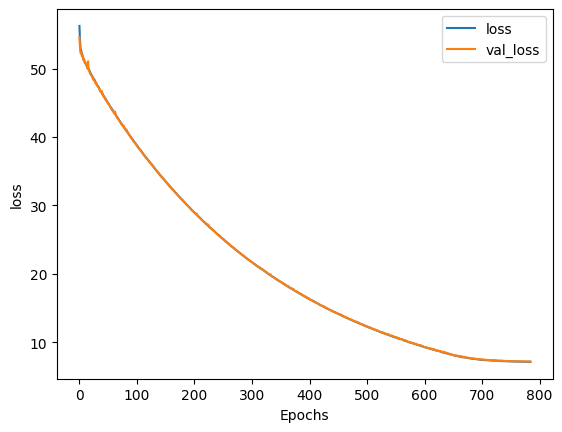

In [17]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "loss")

In [18]:
model.evaluate(
    X_test,
    y_test, verbose=0)

[7.253902912139893, 3.893472909927368, 1.0583804845809937]

In [19]:
from sklearn import metrics
y_pred = model.predict(X_test)

MedAE = median_absolute_error(y_test, y_pred)
print("MedAE X_test:", round(MedAE,5))
y_pred = model.predict(X_train)
MedAE = median_absolute_error(y_train, y_pred)
print("MedAE X_train:", round(MedAE,5))

33/33 [==============================] - 0s 3ms/step
MedAE X_test: 0.54225
 56/293 [====>.........................] - ETA: 0s

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


293/293 [==============================] - 1s 2ms/step
MedAE X_train: 0.42206


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [20]:
TEST_PATH = "/kaggle/input/playground-series-s3e25/test.csv"

test_df = pd.read_csv(TEST_PATH)
test_df.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


In [21]:
log_data = np.log1p(test_df)
log_data = log_data.add_prefix('log10_')

sqrt_data = np.sqrt(test_df)
sqrt_data = sqrt_data.add_prefix('sqrt_')

power_data = test_df ** 2
power_data = power_data.add_prefix('power_')


test_df = pd.concat([test_df, log_data, sqrt_data, power_data], axis = 1)

In [22]:
ypred = model.predict(test_df[X_test.columns])


217/217 [==============================] - 0s 2ms/step


In [23]:
test_df["Hardness"] = ypred
test_df[["id", "Hardness"]]

,id,Hardness
0,10407,2.412113
1,10408,4.823155
2,10409,5.894338
3,10410,5.892421
4,10411,5.879185
...,...,...
6934,17341,5.878131
6935,17342,2.367521
6936,17343,5.909767
6937,17344,2.531850


In [24]:
test_df[["id", "Hardness"]].to_csv("submission_tf.csv", index = False)